In [1]:
# CELDA 1: Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# CELDA 2: Cargar dataset procesado
clean_path = r"D:\UTP\AeroCVer\aerosafe-risk-predictor\data\processed\bird_strikes_clean.csv"

df = pd.read_csv(clean_path)
df.head()

,AircraftType,AirportName,AltitudeBin,MakeModel,WildlifeSize,ConditionsSky,PilotWarned,FlightPhase,Month,Year,IsSevere
0,Airplane,LAGUARDIA NY,"(1000, 2000]",B-737-400,Medium,No Cloud,N,Climb,11,2000,1
1,Airplane,DALLAS/FORT WORTH INTL ARPT,"(-1, 0]",MD-80,Small,Some Cloud,Y,Landing Roll,7,2001,1
2,Airplane,LAKEFRONT AIRPORT,"(30, 50]",C-500,Small,No Cloud,N,Approach,9,2001,0
3,Airplane,SEATTLE-TACOMA INTL,"(30, 50]",B-737-400,Small,Some Cloud,Y,Climb,9,2002,0
4,Airplane,NORFOLK INTL,"(30, 50]",CL-RJ100/200,Small,No Cloud,N,Approach,6,2003,0


In [3]:
# CELDA 3: Definir X (features) e y (target)
X = df.drop(columns=['IsSevere'])
y = df['IsSevere']

# Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

cat_cols, num_cols

(['AircraftType',
  'AirportName',
  'AltitudeBin',
  'MakeModel',
  'WildlifeSize',
  'ConditionsSky',
  'PilotWarned',
  'FlightPhase'],
 ['Month', 'Year'])

In [4]:
# CELDA 4: División de datos y Pipeline de preprocesamiento
# Dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definir cómo transformar las columnas
# handle_unknown='ignore' es vital porque puede haber aeropuertos nuevos en el test
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ])

print(f"Datos divididos: {X_train.shape[0]} muestras para entrenar y {X_test.shape[0]} para probar.")

Datos divididos: 20343 muestras para entrenar y 5086 para probar.


In [5]:
# CELDA 5: Crear y entrenar el Pipeline con el modelo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Entrenar (esto puede tardar unos segundos)
model_pipeline.fit(X_train, y_train)
print("¡Modelo entrenado con éxito!")

¡Modelo entrenado con éxito!


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4595
           1       0.56      0.19      0.28       491

    accuracy                           0.91      5086
   macro avg       0.74      0.58      0.61      5086
weighted avg       0.88      0.91      0.89      5086



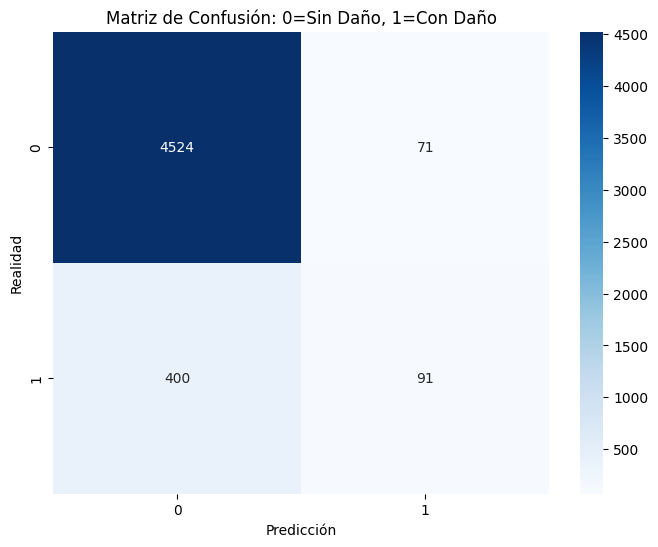

In [6]:
# CELDA 6: Evaluación del modelo
y_pred = model_pipeline.predict(X_test)

print("--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

# Matriz de Confusión visual
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión: 0=Sin Daño, 1=Con Daño')
plt.show()

In [7]:
# CELDA 7: Evaluar diferentes umbrales de decisión

from sklearn.metrics import precision_recall_fscore_support

# Probabilidades de la clase 1 (daño)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

def evaluar_umbral(threshold):
    y_pred_thr = (y_proba >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_thr, average=None, labels=[0, 1]
    )
    print(f"--- Umbral: {threshold:.2f} ---")
    print(f"Clase 0 - precision: {precision[0]:.2f}, recall: {recall[0]:.2f}")
    print(f"Clase 1 - precision: {precision[1]:.2f}, recall: {recall[1]:.2f}")
    print("-----------------------------")

for thr in [0.5, 0.4, 0.3, 0.25, 0.2]:
    evaluar_umbral(thr)

--- Umbral: 0.50 ---
Clase 0 - precision: 0.92, recall: 0.98
Clase 1 - precision: 0.58, recall: 0.20
-----------------------------
--- Umbral: 0.40 ---
Clase 0 - precision: 0.93, recall: 0.97
Clase 1 - precision: 0.54, recall: 0.30
-----------------------------
--- Umbral: 0.30 ---
Clase 0 - precision: 0.94, recall: 0.95
Clase 1 - precision: 0.45, recall: 0.41
-----------------------------
--- Umbral: 0.25 ---
Clase 0 - precision: 0.94, recall: 0.92
Clase 1 - precision: 0.40, recall: 0.47
-----------------------------
--- Umbral: 0.20 ---
Clase 0 - precision: 0.95, recall: 0.89
Clase 1 - precision: 0.35, recall: 0.54
-----------------------------


Reporte de Clasificación con umbral = 0.3
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4595
           1       0.45      0.41      0.43       491

    accuracy                           0.89      5086
   macro avg       0.69      0.68      0.68      5086
weighted avg       0.89      0.89      0.89      5086



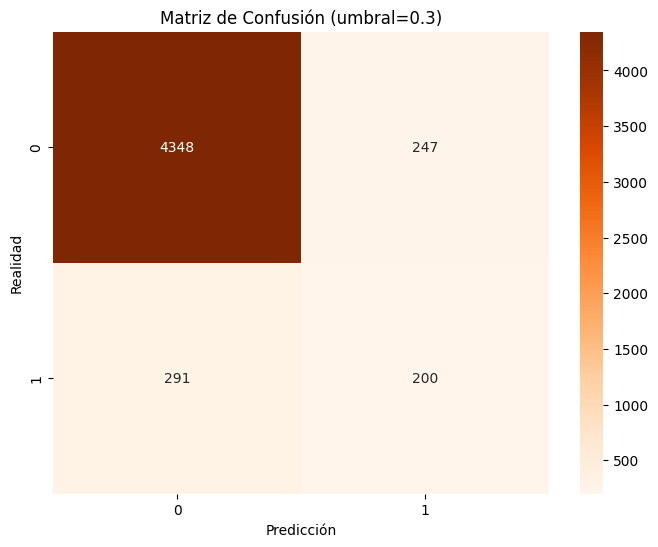

In [8]:
# CELDA 8: Matriz de confusión con umbral ajustado

best_threshold = 0.30  # puedes cambiar a 0.25 si quieres priorizar aún más el recall

y_pred_best = (y_proba >= best_threshold).astype(int)

print(f"Reporte de Clasificación con umbral = {best_threshold}")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title(f'Matriz de Confusión (umbral={best_threshold})')
plt.show()

### 5. Conclusiones del modelo de clasificación básica

- Se entrenó un modelo `RandomForestClassifier` usando variables operacionales.
- El dataset está desbalanceado: los casos con `IsSevere = 1` (daño) son minoría.
- **Desempeño Base (Umbral 0.50):** F1 ≈ 0.28 y recall ≈ 0.19 para la clase con daño.

#### Optimización del Umbral de Riesgo
- Con el umbral estándar de 0.5, el modelo detecta solo ~19% de los incidentes con daño.
- **Al reducir el umbral a 0.30**, el recall de la clase 1 aumenta al **41%** (detectando 200 casos reales de daño frente a los 91 iniciales).
- Este ajuste permite priorizar la **seguridad operativa**, aceptando un incremento en falsas alarmas (247 casos) a cambio de omitir menos incidentes graves.

In [9]:
# CELDA 9: Guardar el modelo para uso futuro
import joblib
import os

# Definir ruta de guardado
model_path = r"D:\UTP\AeroCVer\aerosafe-risk-predictor\data\processed\rf_model_risk.pkl"

# Guardar el pipeline completo (incluye el preprocesador y el modelo)
joblib.dump(model_pipeline, model_path)

print(f"¡Modelo guardado exitosamente en: {model_path}")

¡Modelo guardado exitosamente en: D:\UTP\AeroCVer\aerosafe-risk-predictor\data\processed\rf_model_risk.pkl


In [10]:
# CELDA 10: Cargar el modelo guardado y hacer una predicción de ejemplo

import joblib
import pandas as pd

# Ruta donde guardaste el modelo
model_path = r"D:\UTP\AeroCVer\aerosafe-risk-predictor\data\processed\rf_model_risk.pkl"

# Cargar el pipeline completo (preprocesado + RandomForest)
loaded_model = joblib.load(model_path)
print("Modelo cargado correctamente desde el archivo .pkl")

Modelo cargado correctamente desde el archivo .pkl


In [11]:
# CELDA 11: Definir un vuelo de ejemplo y predecir el riesgo

# Debe tener las MISMAS columnas que X: 
# ['AircraftType', 'AirportName', 'AltitudeBin', 'MakeModel',
#  'WildlifeSize', 'ConditionsSky', 'PilotWarned', 'FlightPhase',
#  'Month', 'Year']

ejemplo = {
    "AircraftType": "Airplane",
    "AirportName": "LAGUARDIA NY",
    "AltitudeBin": "(1000, 2000]",
    "MakeModel": "B-737-400",
    "WildlifeSize": "Medium",
    "ConditionsSky": "No Cloud",
    "PilotWarned": "N",
    "FlightPhase": "Climb",
    "Month": 11,
    "Year": 2000,
}

df_ejemplo = pd.DataFrame([ejemplo])

# Usamos el modelo cargado
prob_dano = loaded_model.predict_proba(df_ejemplo)[:, 1][0]

# Aplicar el mismo umbral que definimos antes (0.30)
best_threshold = 0.30
pred_clase = int(prob_dano >= best_threshold)

print("Vuelo de ejemplo:")
print(df_ejemplo)
print("\nProbabilidad estimada de daño:", round(prob_dano, 3))
print(f"Clasificación final con umbral {best_threshold} (1=Con daño, 0=Sin daño):", pred_clase)

Vuelo de ejemplo:
  AircraftType   AirportName   AltitudeBin  MakeModel WildlifeSize  \
0     Airplane  LAGUARDIA NY  (1000, 2000]  B-737-400       Medium   

  ConditionsSky PilotWarned FlightPhase  Month  Year  
0      No Cloud           N       Climb     11  2000  

Probabilidad estimada de daño: 0.74
Clasificación final con umbral 0.3 (1=Con daño, 0=Sin daño): 1


### 6. Demo de predicción de riesgo

Se guardó el modelo entrenado (`rf_model_risk.pkl`) y se construyó una función de prueba que,
dado un vuelo con sus características (tipo de aeronave, aeropuerto, altura, condiciones del cielo,
etc.), calcula:

- La probabilidad estimada de que el impacto cause daño (`IsSevere = 1`).
- Una clasificación final usando el umbral 0.30 (1 = con daño, 0 = sin daño).

De esta forma, el modelo puede integrarse en una herramienta que, ante un nuevo vuelo o escenario,
entregue una estimación automática del riesgo de impacto con daño.